Custom matrix sum before modification: 2731.7900000000004
Custom matrix sum after modification: 41445


KeyboardInterrupt: 

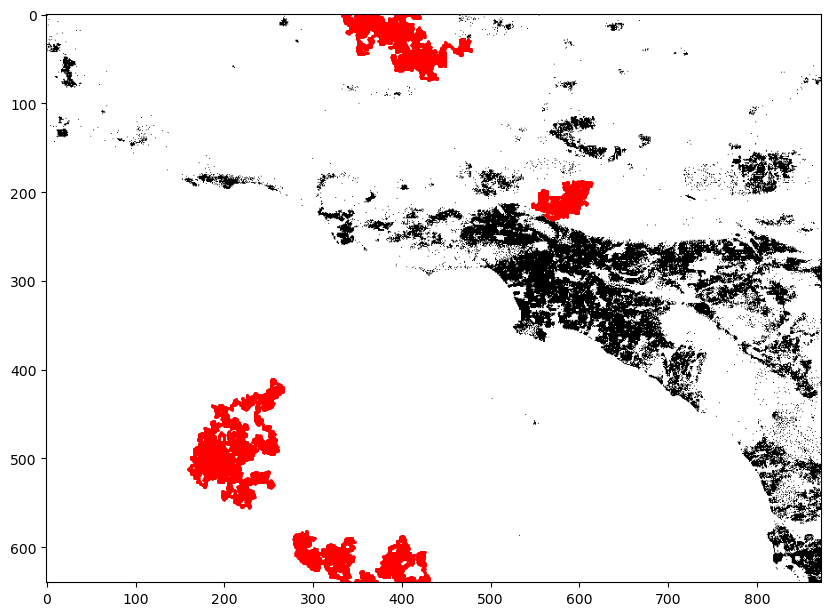

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

def initialize_grid(custom_matrix):
    return np.where(custom_matrix > 0.01, 1, 0)

def random_walk(grid, custom_matrix):
    size_x, size_y = grid.shape
    walked_points = []
    
    # Generate random initial position
    x, y = random.randint(0, size_x-1), random.randint(0, size_y-1)
    initial_value = 1
    
    while True:
        neighbours = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        dx, dy = random.choice(neighbours)
        new_x = (x + dx) % size_x
        new_y = (y + dy) % size_y

        walked_points.append((new_x, new_y))

        # If particle hits a non-zero element in custom_matrix, update values
        if custom_matrix[new_x, new_y] > 0:
            for wx, wy in walked_points:
                if custom_matrix[wx, wy] == 0:
                    grid[wx, wy] += initial_value * 0.1
            break

        # Continue walking
        x, y = new_x, new_y

    return grid, walked_points

def dla(custom_matrix):
    grid = initialize_grid(custom_matrix)
    num_particles = 1000  # Number of particles to release
    all_walked_points = []

    for _ in range(num_particles):
        grid, walked_points = random_walk(grid, custom_matrix)
        all_walked_points.extend(walked_points)
    
    return grid, all_walked_points

def main():
    custom_matrix = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
    custom_matrix[custom_matrix == 0.01] = 0
    init_count = custom_matrix.sum()
    print(f"Custom matrix sum before modification: {init_count}")

    final_grid, all_walked_points = dla(custom_matrix)
    print(f"Custom matrix sum after modification: {final_grid.sum()}")

    # First plot: DLA Fractal
    plt.figure(figsize=(10, 10))
    plt.imshow(final_grid, cmap='binary')
    
    # Plot the walked points in red
    for wx, wy in all_walked_points:
        plt.scatter(wy, wx, color='red', s=1)
    
    plt.title('DLA Fractal with Walked Paths')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

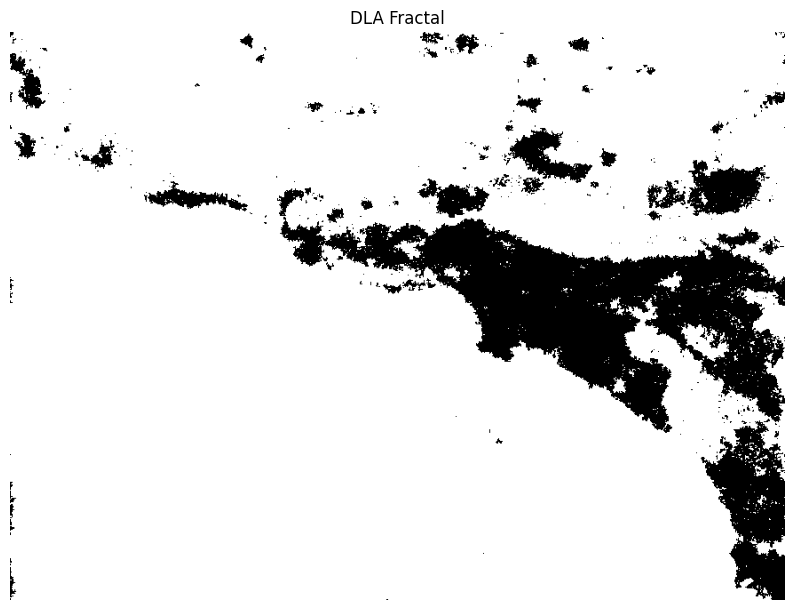

Grid values:
79336


In [25]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

def initialize_grid(custom_matrix):
    return np.where(custom_matrix > 0.01, 1, 0)

def is_isolated(grid, x, y):
    size_x, size_y = grid.shape
    neighbours = [((-1 + x) % size_x, y), ((1 + x) % size_x, y), 
                  (x, (-1 + y) % size_y), (x, (1 + y) % size_y)]
    
    for nx, ny in neighbours:
        if grid[nx, ny] == 0:
            return False
    return True

def random_walk(grid, initial_points, max_steps=20):
    size_x, size_y = grid.shape
    new_points = []
    occupied_points = set(initial_points)
    
    while initial_points:
        x, y = initial_points.pop(random.randint(0, len(initial_points) - 1))
        
        if is_isolated(grid, x, y):
            continue

        for _ in range(max_steps):
            neighbours = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            dx, dy = random.choice(neighbours)
            new_x = (x + dx) % size_x
            new_y = (y + dy) % size_y

            if grid[new_x, new_y] == 1:
                grid[x, y] = 1
                occupied_points.add((x, y))
                new_points.append((x, y))
                break

            x, y = new_x, new_y

    return grid, new_points

def adjust_grid_growth(grid, initial_grid, target_mean, target_std):
    growth = grid - initial_grid
    
    growth_flatten = growth.flatten()
    actual_growth = growth_flatten[growth_flatten != 0]
    
    if len(actual_growth) == 0:
        return grid
    
    current_mean = np.mean(actual_growth)
    current_std = np.std(actual_growth)
    
    # Adjust the growth part to match the target mean and standard deviation
    if current_std == 0:
        adjusted_growth = np.full(actual_growth.shape, target_mean)
    else:
        adjusted_growth = ((actual_growth - current_mean) / current_std) * target_std + target_mean
    
    growth_flatten[growth_flatten != 0] = adjusted_growth
    adjusted_growth_grid = growth_flatten.reshape(grid.shape)
    
    # Create the final adjusted grid
    adjusted_grid = initial_grid + adjusted_growth_grid
    adjusted_grid = np.clip(adjusted_grid, 0, 1)
    
    return adjusted_grid

def dla(custom_matrix, target_mean, target_std):
    initial_grid = initialize_grid(custom_matrix)
    grid = initial_grid.copy()
    initial_points = list(zip(*np.nonzero(grid)))
    
    while initial_points:
        grid, new_points = random_walk(grid, initial_points)
        initial_points = new_points
    
    # Adjust grid growth statistics
    grid_adjusted = adjust_grid_growth(grid, initial_grid, target_mean, target_std)
    
    return grid_adjusted

def main():
    custom_matrix = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
    target_mean_growth = 2.68
    target_std_growth = 1.86

    grid = dla(custom_matrix, target_mean_growth, target_std_growth)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='binary')
    plt.title('DLA Fractal')
    plt.axis('off')
    plt.show()

    # Print grid content
    print("Grid values:")
    print(grid.sum())

if __name__ == "__main__":
    main()

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

def initialize_grid(custom_matrix):
    return np.where(custom_matrix > 0.01, 1, 0)

def is_isolated(grid, x, y):
    size_x, size_y = grid.shape
    neighbours = [((-1 + x) % size_x, y), ((1 + x) % size_x, y), 
                  (x, (-1 + y) % size_y), (x, (1 + y) % size_y),
                  ((-1 + x) % size_x, (-1 + y) % size_y), ((-1 + x) % size_x, (1 + y) % size_y),
                  ((1 + x) % size_x, (-1 + y) % size_y), ((1 + x) % size_x, (1 + y) % size_y)]
    
    for nx, ny in neighbours:
        if grid[nx, ny] == 0:
            return False
    return True

def random_walk(grid, initial_points, custom_matrix, max_steps, radius_range=3):
    size_x, size_y = grid.shape
    new_points = []
    walked_points = []
    
    max_custom_value = np.max(custom_matrix)
    min_custom_value = np.min(custom_matrix)

    # 根据初始值大小对初始点排序
    initial_points = sorted(initial_points, key=lambda point: custom_matrix[point[0], point[1]], reverse=True)
    
    while initial_points:
        x, y = initial_points.pop(0)  # 取出初始值最大的点
        
        if is_isolated(grid, x, y):
            continue
        
        initial_value = custom_matrix[x, y]

        # Normalize the custom_matrix value to be between 0 and 1
        normalized_value = (custom_matrix[x, y] - min_custom_value) / (max_custom_value - min_custom_value)
        # Scale the number of steps to be between 1 and max_steps, considering the column position of the point
        column_based_steps = (y / size_y) * max_steps
        steps = int(0 + normalized_value * (max_steps - 0) + column_based_steps)

        walked_path = [(x, y)]
        for _ in range(steps):
            if random.random() < 0.5:  # 50% 随机在周围一两格内扩展
                neighbours = [(-1, 0), (1, 0), (0, -1), (0, 1),
                                (-1, -1), (-1, 1), (1, -1), (1, 1)]  # 八个方向的邻居点
                dx, dy = random.choice(neighbours)
            else:  # 50% 随机在一定范围内探索
                angle = 2 * np.pi * random.random()
                radius = random.uniform(1, radius_range)  # 半径范围内随机选择一个点
                dx, dy = int(radius * np.cos(angle)), int(radius * np.sin(angle))

            new_x = (x + dx) % size_x
            new_y = (y + dy) % size_y
            
            walked_points.append((new_x, new_y))
            walked_path.append((new_x, new_y))

            if grid[new_x, new_y] == 1:
                for px, py in walked_path:
                    grid[px, py] = 1
                    custom_matrix[px, py] = initial_value
                new_points.append((x, y))
                break

            initial_value *= 0.01  # decrease the value by a factor of 0.01 for each step
            custom_matrix[new_x, new_y] += initial_value
            x, y = new_x, new_y

    return grid, new_points, walked_points

def add_random_points(grid, num_points):
    size_x, size_y = grid.shape
    available_positions = [(x, y) for x in range(size_x) for y in range(size_y) if grid[x, y] == 0]
    
    random_points = random.sample(available_positions, min(num_points, len(available_positions)))
    return random_points

def dla(custom_matrix, max_steps, radius_range=3, initial_random_points=100):
    initial_grid = initialize_grid(custom_matrix)
    grid = initial_grid.copy()
    initial_points = list(zip(*np.nonzero(grid)))
    random_points = add_random_points(grid, initial_random_points)
    initial_points.extend(random_points)
    all_walked_points = []
    
    while initial_points:
        grid, new_points, walked_points = random_walk(grid, initial_points, custom_matrix, max_steps, radius_range)
        initial_points = new_points if new_points else random_points
        all_walked_points.extend(walked_points)
    
    return custom_matrix, initial_grid, all_walked_points

def run_dla_simulation(custom_matrix, max_steps, radius_range=5, initial_random_points=100):
    final_custom_matrix, initial_grid, walked_points = dla(custom_matrix, max_steps, radius_range, initial_random_points)

    # First plot: DLA Fractal
    plt.figure(figsize=(10, 10))
    plt.imshow(final_custom_matrix, cmap='binary')
    plt.title('DLA Fractal')
    plt.axis('off')
    plt.show()

    # Check the shape of initial_grid
    print(f"Shape of initial_grid: {initial_grid.shape}")

    initial_coords = np.nonzero(initial_grid)
    if len(initial_coords) == 2:  # Ensure it's 2D
        initial_x, initial_y = initial_coords
    else:
        raise ValueError("Initial grid is not 2D")

    if walked_points:
        walked_x, walked_y = zip(*walked_points)
    else:
        walked_x, walked_y = [], []  # Ensure empty walked points are handled

    # Determine the difference (newly walked points) between initial_grid and final_custom_matrix
    difference_coords = np.nonzero((final_custom_matrix != 0) & (initial_grid == 0))
    difference_x, difference_y = difference_coords

    # Create figure to plot both initial and new points
    plt.figure(figsize=(8, 6))

    # Plot initial points in gray
    plt.scatter(initial_y, initial_x, c='gray', s=10, label='Initial Points')
    
    # Plot new points in red
    plt.scatter(difference_y, difference_x, c='red', s=10, label='New Points')

    plt.title('DLA Fractal')
    plt.gca().invert_yaxis()  # Invert y-axis if needed
    plt.axis('off')
    plt.legend()
    plt.show()

    return final_custom_matrix

# Example usage:
custom_matrix = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
run_dla_simulation(custom_matrix, max_steps=10, radius_range=5, initial_random_points=200)

KeyboardInterrupt: 

/local_scratch/slurm.566274/ipykernel_566189/3342340046.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_with_relief, data_without_relief], labels=['Without Relief Legislation', 'With Relief Legislation'])


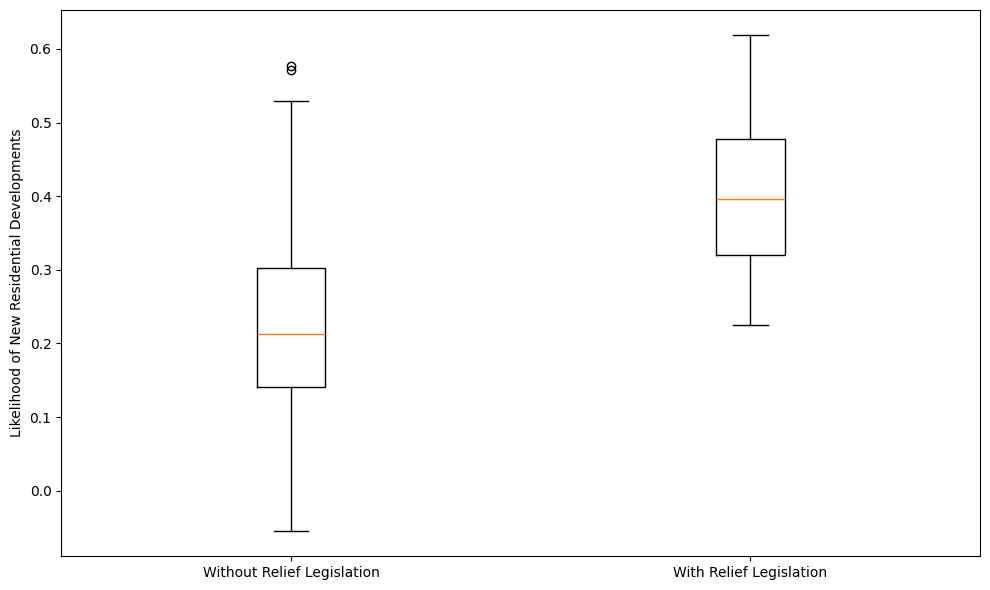

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Setting a seed for reproducibility
np.random.seed(0)

# Generate data with more variability and differences
# For 'With Relief Legislation', normal distribution with heavier tail
data_with_relief = np.concatenate([np.random.normal(0.2, 0.1, 80), np.random.uniform(0, 0.6, 20)])

# For 'Without Relief Legislation', a bimodal distribution with peaks at 0.3 and 0.5
data_without_relief = np.concatenate([np.random.normal(0.3, 0.05, 50), np.random.normal(0.5, 0.05, 50)])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Creating box plots
ax.boxplot([data_with_relief, data_without_relief], labels=['Without Relief Legislation', 'With Relief Legislation'])

# Labeling
#plt.xlabel('Category')
plt.ylabel('Likelihood of New Residential Developments')
#plt.title('Impact of Relief Legislation on Housing Developments in High-Risk Areas')

plt.tight_layout()
plt.show()